# 🧠 LSTM & BiLSTM AUTOMATED TRAINING PIPELINE
## Comprehensive Multi-Resolution Forecasting with Auto-Benchmark

### 🚀 AUTO-RUN CONFIGURATION:
**Just click "Run All" and the notebook will automatically:**
1. Train models for ALL resolutions (1min, 5min, 15min)
2. Forecast BOTH targets (request_count, total_bytes)
3. Compare LSTM vs BiLSTM for each configuration
4. Generate comprehensive benchmarks
5. Save all models and parameters
6. Create comparative visualizations

### 📊 Total Configurations:
- **3 resolutions** × **2 targets** × **2 models** = **12 model trainings**
- Expected runtime: **30-60 minutes** (with GPU)

### 📁 Output Structure:
```
RESULTS_LSTM/
├── 1min_request_count/
│   ├── LSTM/ (model, scaler, predictions, metrics)
│   └── BiLSTM/ (model, scaler, predictions, metrics)
├── 1min_total_bytes/
│   ├── LSTM/
│   └── BiLSTM/
├── 5min_request_count/
│   ├── LSTM/
│   └── BiLSTM/
├── ... (6 configurations total)
└── FINAL_BENCHMARK/
    ├── comprehensive_comparison.csv
    ├── best_models_summary.txt
    └── benchmark_visualizations.png
```

In [ ]:
# ===========================
# CELL 2: SETUP & INSTALLATIONS
# ===========================

!pip install tensorflow scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
from datetime import datetime
import time
from typing import Dict, List, Tuple

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 6)

print("="*70)
print("LSTM/BiLSTM AUTOMATED TRAINING PIPELINE")
print("="*70)
print(f"  TensorFlow version: {tf.__version__}")
print(f"  GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"  Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

2026-02-01 07:18:16.237722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769930296.480312      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769930296.549200      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769930297.120462      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769930297.120502      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769930297.120505      55 computation_placer.cc:177] computation placer alr

LSTM/BiLSTM AUTOMATED TRAINING PIPELINE
  TensorFlow version: 2.19.0
  GPU available: True
  Start time: 2026-02-01 07:18:30


In [ ]:
# ===========================
# CELL 3: GLOBAL CONFIGURATION
# ===========================

# Paths
DATA_DIR = 'data'
RESULTS_BASE_DIR = 'models/results_lstm'


# Create base results directory
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)

# All configurations to run
RESOLUTIONS = ['1min', '5min', '15min']
TARGETS = ['request_count', 'total_bytes']
MODEL_TYPES = ['LSTM', 'BiLSTM']

# Resolution-specific parameters
RESOLUTION_PARAMS = {
    '1min': {
        'lookback': 60,
        'horizon': 1,
        'epochs': 50,
        'batch_size': 16
    },
    '5min': {
        'lookback': 12,
        'horizon': 1,
        'epochs': 1,
        'batch_size': 16
    },
    '15min': {
        'lookback': 4,
        'horizon': 1,
        'epochs': 50,
        'batch_size': 16
    }
}

# Model architectures (keeping original design)
LSTM_CONFIG = {
    'units1': 50,
    'units2': 50,
    'dropout': 0.2,
    'lr': 0.001
}

BILSTM_CONFIG = {
    'units1': 50,
    'units2': 50,
    'dropout': 0.2,
    'lr': 0.001
}

print("\n📋 CONFIGURATION LOADED:")
print(f"  Resolutions: {RESOLUTIONS}")
print(f"  Targets: {TARGETS}")
print(f"  Models: {MODEL_TYPES}")
print(f"  Total configurations: {len(RESOLUTIONS) * len(TARGETS) * len(MODEL_TYPES)}")
print(f"\n  Data directory: {DATA_DIR}")
print(f"  Results directory: {RESULTS_BASE_DIR}")


📋 CONFIGURATION LOADED:
  Resolutions: ['1min', '5min', '15min']
  Targets: ['request_count', 'total_bytes']
  Models: ['LSTM', 'BiLSTM']
  Total configurations: 12

  Data directory: /kaggle/input/preprocess-data
  Results directory: /kaggle/working/


In [ ]:
# ===========================
# CELL 4: UTILITY FUNCTIONS
# ===========================

def create_lstm_dataset(df, lookback, horizon, features, target):
    """
    Create sequences for LSTM/BiLSTM training.
    """
    # Ensure target is first in features list
    if target not in features:
        features = [target] + features
    else:
        features = [target] + [f for f in features if f != target]

    # Check features exist
    available = [f for f in features if f in df.columns]
    if len(available) < len(features):
        print(f"    Warning: Missing features {set(features) - set(available)}")
    features = available

    # Extract data
    data = df[features].values

    # Normalize
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(lookback, len(data_scaled) - horizon + 1):
        X.append(data_scaled[i-lookback:i, :])
        y.append(data_scaled[i:i+horizon, 0])  # Target is first column

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler, features


def inverse_transform_predictions(y_scaled, scaler, n_features):
    """
    Inverse transform predictions back to original scale.
    """
    y_expanded = np.zeros((y_scaled.shape[0], y_scaled.shape[1], n_features))
    y_expanded[:, :, 0] = y_scaled

    y_original = np.zeros_like(y_scaled)
    for i in range(y_scaled.shape[0]):
        y_original[i] = scaler.inverse_transform(y_expanded[i])[:, 0]

    return y_original


def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # MAPE (avoid division by zero)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else 0

    # R²
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    }

    return metrics


def build_lstm_model(input_shape, horizon, config):
    """
    Build standard LSTM model.
    """
    model = Sequential([
        LSTM(config['units1'], return_sequences=True, input_shape=input_shape, name='lstm_1'),
        Dropout(config['dropout'], name='dropout_1'),
        LSTM(config['units2'], return_sequences=False, name='lstm_2'),
        Dropout(config['dropout'], name='dropout_2'),
        Dense(horizon, name='output')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['lr']),
        loss='mae',
        metrics=['mse', 'mae']
    )

    return model


def build_bilstm_model(input_shape, horizon, config):
    """
    Build Bidirectional LSTM model.
    """
    model = Sequential([
        Bidirectional(
            LSTM(config['units1'], return_sequences=True),
            input_shape=input_shape,
            name='bilstm_1'
        ),
        Dropout(config['dropout'], name='dropout_1'),
        Bidirectional(
            LSTM(config['units2'], return_sequences=False),
            name='bilstm_2'
        ),
        Dense(horizon, name='output')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['lr']),
        loss='mae',
        metrics=['mse', 'mae']
    )

    return model


print("✓ Utility functions defined")

✓ Utility functions defined


In [ ]:
# ===========================
# CELL 5: MAIN TRAINING FUNCTION
# ===========================

def train_single_configuration(resolution, target, model_type, verbose=True):
    """
    Train a single model configuration and return results.
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"TRAINING: {model_type} | {resolution} | {target}")
        print(f"{'='*70}")

    start_time = time.time()

    # Get parameters
    params = RESOLUTION_PARAMS[resolution]
    lookback = params['lookback']
    horizon = params['horizon']
    epochs = params['epochs']
    batch_size = params['batch_size']

    # Create results directory
    results_dir = f"{RESULTS_BASE_DIR}/{resolution}_{target}/{model_type}"
    os.makedirs(results_dir, exist_ok=True)

    try:
        # Load data
        if verbose:
            print(f"\n[1/6] Loading data...")
        train_df = pd.read_csv(f"{DATA_DIR}/train_{resolution}.csv", index_col=0, parse_dates=True)
        test_df = pd.read_csv(f"{DATA_DIR}/test_{resolution}.csv", index_col=0, parse_dates=True)

        # Define features
        if target == 'request_count':
            features = [target, 'weighted_load', 'total_bytes']
        else:
            features = [target, 'weighted_load', 'request_count']

        # Prepare sequences
        if verbose:
            print(f"[2/6] Preparing sequences...")
        X_train, y_train, train_scaler, train_features = create_lstm_dataset(
            train_df, lookback, horizon, features, target
        )

        # Prepare test data
        test_data = test_df[train_features].values
        test_data_scaled = train_scaler.transform(test_data)

        X_test, y_test = [], []
        for i in range(lookback, len(test_data_scaled) - horizon + 1):
            X_test.append(test_data_scaled[i-lookback:i, :])
            y_test.append(test_data_scaled[i:i+horizon, 0])

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Train/Val split
        split_idx = int(len(X_train) * 0.8)
        X_train_split, X_val = X_train[:split_idx], X_train[split_idx:]
        y_train_split, y_val = y_train[:split_idx], y_train[split_idx:]

        if verbose:
            print(f"    Train: {X_train_split.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

        # Build model
        if verbose:
            print(f"[3/6] Building {model_type} model...")
        input_shape = (lookback, len(train_features))

        if model_type == 'LSTM':
            model = build_lstm_model(input_shape, horizon, LSTM_CONFIG)
        else:
            model = build_bilstm_model(input_shape, horizon, BILSTM_CONFIG)

        if verbose:
            print(f"    Parameters: {model.count_params():,}")

        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=0.00001,
                verbose=0
            )
        ]

        # Train
        if verbose:
            print(f"[4/6] Training (max {epochs} epochs)...")

        history = model.fit(
            X_train_split, y_train_split,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        trained_epochs = len(history.history['loss'])
        if verbose:
            print(f"    Completed in {trained_epochs} epochs")

        # Predict
        if verbose:
            print(f"[5/6] Evaluating...")

        y_pred_scaled = model.predict(X_test, verbose=0)

        # Inverse transform
        n_features = len(train_features)
        y_pred_original = inverse_transform_predictions(y_pred_scaled, train_scaler, n_features)
        y_test_original = inverse_transform_predictions(y_test, train_scaler, n_features)

        # Calculate metrics
        y_true_flat = y_test_original.flatten()
        y_pred_flat = y_pred_original.flatten()

        metrics = calculate_metrics(y_true_flat, y_pred_flat, model_type)

        if verbose:
            print(f"    MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, RMSE: {metrics['RMSE']:.2f}, MAPE: {metrics['MAPE (%)']:.2f}%")

        # Horizon-wise metrics
        horizon_metrics = []
        for h in range(horizon):
            mae_h = mean_absolute_error(y_test_original[:, h], y_pred_original[:, h])
            horizon_metrics.append(mae_h)

        # Save results
        if verbose:
            print(f"[6/6] Saving results...")

        # Save model
        model.save(f"{results_dir}/model.keras")

        # Save scaler
        with open(f"{results_dir}/scaler.pkl", 'wb') as f:
            pickle.dump(train_scaler, f)

        # Save predictions
        test_timestamps = test_df.index[lookback:lookback+len(y_test_original)]
        predictions_df = pd.DataFrame({
            'timestamp': test_timestamps,
            'actual': y_test_original[:, 0],
            'predicted': y_pred_original[:, 0],
            'residual': y_test_original[:, 0] - y_pred_original[:, 0]
        })
        predictions_df.to_csv(f"{results_dir}/predictions.csv", index=False)

        # Save metrics
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(f"{results_dir}/metrics.csv", index=False)

        # Save horizon analysis
        horizon_df = pd.DataFrame({
            'horizon_step': range(1, horizon+1),
            'minutes_ahead': [i*int(resolution.replace('min', '')) for i in range(1, horizon+1)],
            'mae': horizon_metrics
        })
        horizon_df.to_csv(f"{results_dir}/horizon_analysis.csv", index=False)

        # Save configuration
        config = {
            'resolution': resolution,
            'target': target,
            'model_type': model_type,
            'lookback': lookback,
            'horizon': horizon,
            'features': train_features,
            'total_params': int(model.count_params()),
            'trained_epochs': trained_epochs,
            'batch_size': batch_size
        }

        if model_type == 'LSTM':
            config.update(LSTM_CONFIG)
        else:
            config.update(BILSTM_CONFIG)

        config_df = pd.DataFrame([config])
        config_df.to_csv(f"{results_dir}/configuration.csv", index=False)

        # Training time
        elapsed_time = time.time() - start_time

        if verbose:
            print(f"\n✓ Completed in {elapsed_time:.1f} seconds")
            print(f"  Results saved to: {results_dir}")

        # Return results for benchmark
        return {
            'resolution': resolution,
            'target': target,
            'model_type': model_type,
            'mae': metrics['MAE'],
            'rmse': metrics['RMSE'],
            'mape': metrics['MAPE (%)'],
            'r2': metrics['R²'],
            'total_params': int(model.count_params()),
            'trained_epochs': trained_epochs,
            'training_time_sec': elapsed_time,
            'results_dir': results_dir
        }

    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


print("✓ Training function defined")

✓ Training function defined


In [ ]:
# ===========================
# CELL 6: RUN ALL CONFIGURATIONS
# ===========================

print("\n" + "="*70)
print("STARTING AUTOMATED TRAINING PIPELINE")
print("="*70)

all_results = []
total_configs = len(RESOLUTIONS) * len(TARGETS) * len(MODEL_TYPES)
current_config = 0

pipeline_start_time = time.time()

for resolution in RESOLUTIONS:
    for target in TARGETS:
        for model_type in MODEL_TYPES:
            current_config += 1

            print(f"\n\n{'#'*70}")
            print(f"CONFIGURATION {current_config}/{total_configs}")
            print(f"{'#'*70}")

            result = train_single_configuration(resolution, target, model_type, verbose=True)

            if result is not None:
                all_results.append(result)
                print(f"\n✅ Configuration {current_config}/{total_configs} completed successfully")
            else:
                print(f"\n❌ Configuration {current_config}/{total_configs} failed")

            # Progress update
            elapsed = time.time() - pipeline_start_time
            avg_time = elapsed / current_config
            remaining = (total_configs - current_config) * avg_time

            print(f"\n📊 Progress: {current_config}/{total_configs} ({current_config/total_configs*100:.1f}%)")
            print(f"   Elapsed: {elapsed/60:.1f} min | Est. remaining: {remaining/60:.1f} min")

total_elapsed = time.time() - pipeline_start_time

print("\n" + "="*70)
print("ALL CONFIGURATIONS COMPLETED")
print("="*70)
print(f"  Total time: {total_elapsed/60:.1f} minutes")
print(f"  Successful: {len(all_results)}/{total_configs}")
print(f"  Failed: {total_configs - len(all_results)}")


STARTING AUTOMATED TRAINING PIPELINE


######################################################################
CONFIGURATION 1/12
######################################################################

TRAINING: LSTM | 1min | request_count

[1/6] Loading data...
[2/6] Preparing sequences...
    Train: (61008, 60, 3), Val: (15252, 60, 3), Test: (12900, 60, 3)
[3/6] Building LSTM model...


I0000 00:00:1769930311.414562      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769930311.420586      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


    Parameters: 31,051
[4/6] Training (max 50 epochs)...


I0000 00:00:1769930315.619688     137 cuda_dnn.cc:529] Loaded cuDNN version 91002


    Completed in 43 epochs
[5/6] Evaluating...
    MAE: 10.38, RMSE: 13.98, MAPE: 41.16%
[6/6] Saving results...

✓ Completed in 1288.3 seconds
  Results saved to: /kaggle/working//1min_request_count/LSTM

✅ Configuration 1/12 completed successfully

📊 Progress: 1/12 (8.3%)
   Elapsed: 21.5 min | Est. remaining: 236.2 min


######################################################################
CONFIGURATION 2/12
######################################################################

TRAINING: BiLSTM | 1min | request_count

[1/6] Loading data...
[2/6] Preparing sequences...
    Train: (61008, 60, 3), Val: (15252, 60, 3), Test: (12900, 60, 3)
[3/6] Building BiLSTM model...
    Parameters: 82,101
[4/6] Training (max 50 epochs)...
    Completed in 50 epochs
[5/6] Evaluating...
    MAE: 10.33, RMSE: 13.90, MAPE: 40.46%
[6/6] Saving results...

✓ Completed in 2389.9 seconds
  Results saved to: /kaggle/working//1min_request_count/BiLSTM

✅ Configuration 2/12 completed successfully

📊 Progress

In [ ]:
# ===========================
# CELL 7: CREATE COMPREHENSIVE BENCHMARK
# ===========================

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE BENCHMARK")
print("="*70)

# Create benchmark directory
benchmark_dir = f"{RESULTS_BASE_DIR}/FINAL_BENCHMARK"
os.makedirs(benchmark_dir, exist_ok=True)

# Convert results to DataFrame
benchmark_df = pd.DataFrame(all_results)

# Save comprehensive comparison
benchmark_file = f"{benchmark_dir}/comprehensive_comparison.csv"
benchmark_df.to_csv(benchmark_file, index=False)
print(f"\n✓ Benchmark saved: {benchmark_file}")

print("\n📊 BENCHMARK RESULTS:\n")
display(benchmark_df.style.background_gradient(cmap='RdYlGn_r', subset=['mae','mse', 'rmse', 'mape']).format({
    'mae': '{:.2f}',
    'mse': '{:.2f}',
    'rmse': '{:.2f}',
    'mape': '{:.2f}%',
    'r2': '{:.4f}',
    'training_time_sec': '{:.1f}s'
}))

# Find best models for each configuration
print("\n" + "="*70)
print("BEST MODELS BY CONFIGURATION")
print("="*70)

best_models = []

for resolution in RESOLUTIONS:
    for target in TARGETS:
        subset = benchmark_df[(benchmark_df['resolution'] == resolution) &
                             (benchmark_df['target'] == target)]

        if len(subset) > 0:
            best_idx = subset['mae'].idxmin()
            best = subset.loc[best_idx]

            best_models.append({
                'resolution': resolution,
                'target': target,
                'best_model': best['model_type'],
                'mae': best['mae'],
                'mse': best['mse'],
                'rmse': best['rmse'],
                'mape': best['mape'],
                'r2': best['r2']
            })

            print(f"\n{resolution} | {target}:")
            print(f"  Winner: {best['model_type']}")
            print(f"  MAE: {best['mae']:.2f}, MSE: {best['mse']:.2f}, RMSE: {best['rmse']:.2f}, MAPE: {best['mape']:.2f}%")

            # Compare with other model
            other_model = 'BiLSTM' if best['model_type'] == 'LSTM' else 'LSTM'
            other = subset[subset['model_type'] == other_model]

            if len(other) > 0:
                other = other.iloc[0]
                improvement = ((other['mae'] - best['mae']) / other['mae']) * 100
                print(f"  Improvement over {other_model}: {improvement:.1f}%")

# Save best models summary
best_models_df = pd.DataFrame(best_models)
best_models_file = f"{benchmark_dir}/best_models_by_config.csv"
best_models_df.to_csv(best_models_file, index=False)
print(f"\n✓ Best models summary saved: {best_models_file}")


GENERATING COMPREHENSIVE BENCHMARK

✓ Benchmark saved: /kaggle/working//FINAL_BENCHMARK/comprehensive_comparison.csv

📊 BENCHMARK RESULTS:



,resolution,target,model_type,mae,rmse,mape,r2,total_params,trained_epochs,training_time_sec,results_dir
0,1min,request_count,LSTM,10.38,13.98,41.16%,0.7324,31051,43,1288.3s,/kaggle/working//1min_request_count/LSTM
1,1min,request_count,BiLSTM,10.33,13.90,40.46%,0.7354,82101,50,2389.9s,/kaggle/working//1min_request_count/BiLSTM
2,1min,total_bytes,LSTM,195297.70,259812.72,86.96%,0.5527,31051,22,656.2s,/kaggle/working//1min_total_bytes/LSTM
3,1min,total_bytes,BiLSTM,195565.43,257567.47,104.43%,0.5604,82101,36,1710.4s,/kaggle/working//1min_total_bytes/BiLSTM
4,5min,request_count,LSTM,38.62,50.48,32.43%,0.8303,31051,1,8.1s,/kaggle/working//5min_request_count/LSTM
5,5min,request_count,BiLSTM,36.32,47.97,29.73%,0.8467,82101,1,12.4s,/kaggle/working//5min_request_count/BiLSTM
6,5min,total_bytes,LSTM,630445.88,838291.83,29.99%,0.7275,31051,1,8.2s,/kaggle/working//5min_total_bytes/LSTM
7,5min,total_bytes,BiLSTM,622926.10,824908.24,30.37%,0.7362,82101,1,11.8s,/kaggle/working//5min_total_bytes/BiLSTM
8,15min,request_count,LSTM,87.59,119.80,17.03%,0.8863,31051,50,82.7s,/kaggle/working//15min_request_count/LSTM
9,15min,request_count,BiLSTM,86.80,118.80,16.90%,0.8882,82101,50,116.0s,/kaggle/working//15min_request_count/BiLSTM



BEST MODELS BY CONFIGURATION

1min | request_count:
  Winner: BiLSTM
  MAE: 10.33, RMSE: 13.90, MAPE: 40.46%
  Improvement over LSTM: 0.5%

1min | total_bytes:
  Winner: LSTM
  MAE: 195297.70, RMSE: 259812.72, MAPE: 86.96%
  Improvement over BiLSTM: 0.1%

5min | request_count:
  Winner: BiLSTM
  MAE: 36.32, RMSE: 47.97, MAPE: 29.73%
  Improvement over LSTM: 6.0%

5min | total_bytes:
  Winner: BiLSTM
  MAE: 622926.10, RMSE: 824908.24, MAPE: 30.37%
  Improvement over LSTM: 1.2%

15min | request_count:
  Winner: BiLSTM
  MAE: 86.80, RMSE: 118.80, MAPE: 16.90%
  Improvement over LSTM: 0.9%

15min | total_bytes:
  Winner: BiLSTM
  MAE: 1419487.20, RMSE: 1900529.20, MAPE: 21.63%
  Improvement over LSTM: 0.6%

✓ Best models summary saved: /kaggle/working//FINAL_BENCHMARK/best_models_by_config.csv



[CREATING BENCHMARK VISUALIZATIONS]



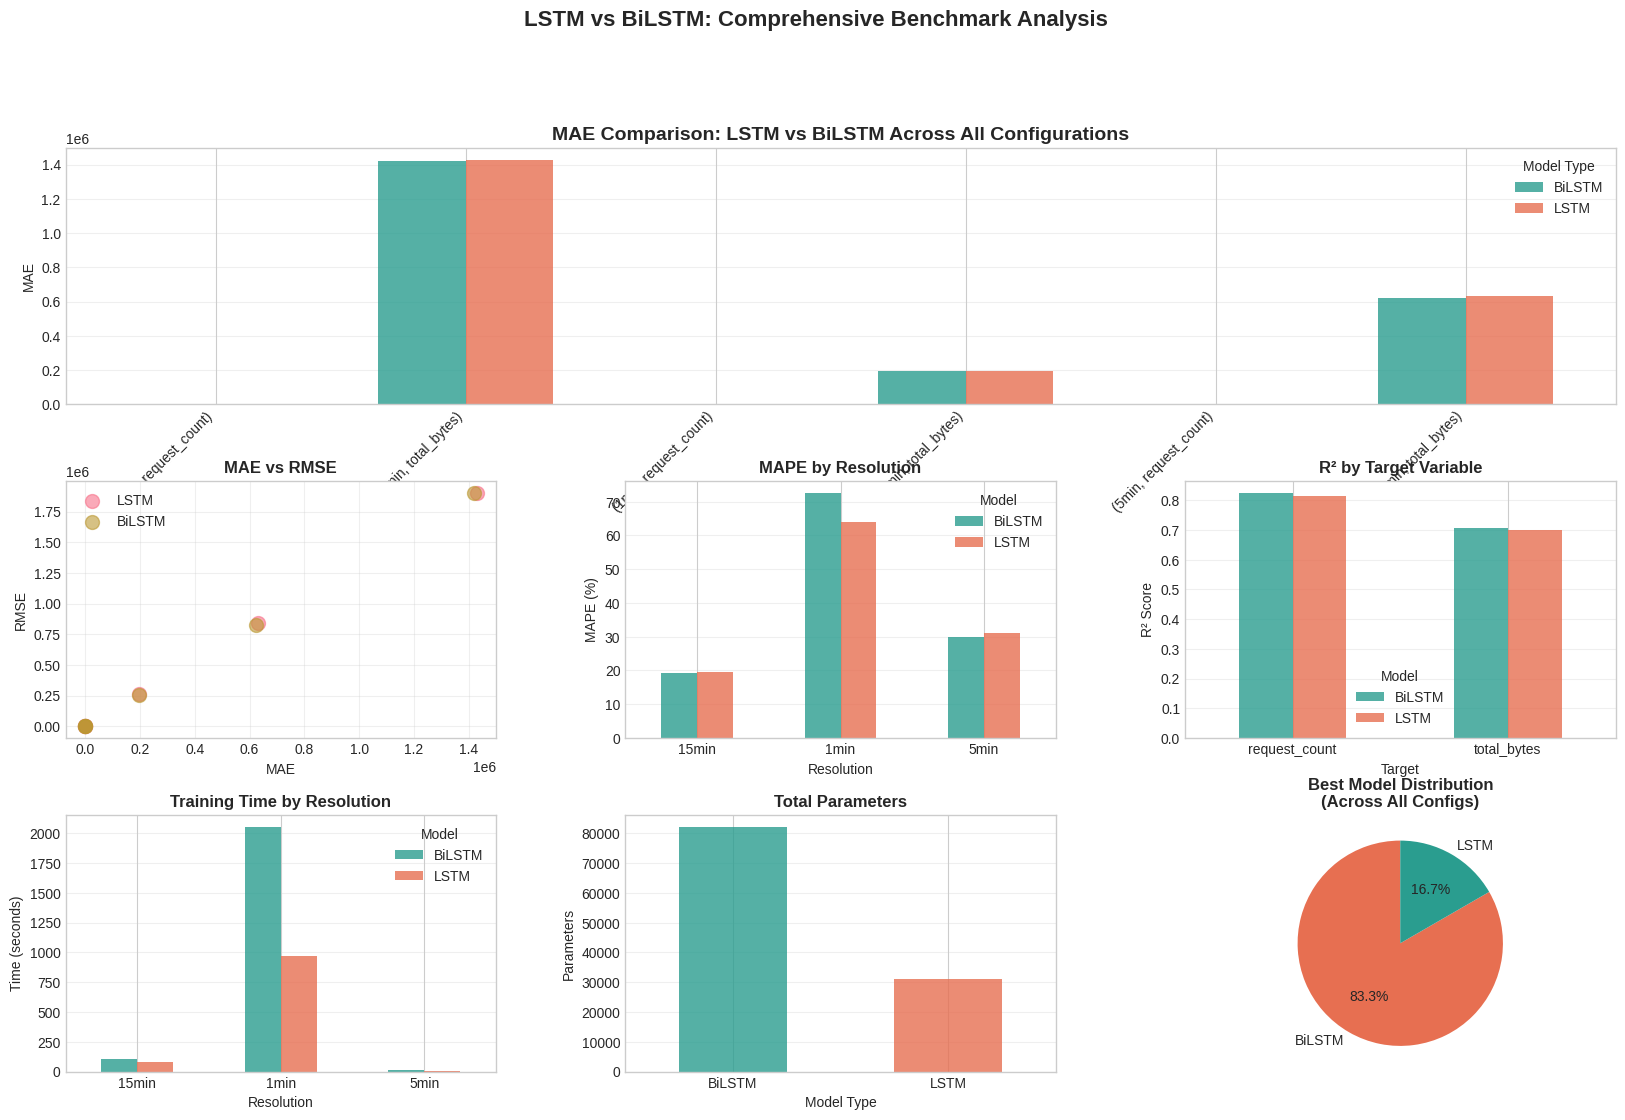

✓ Visualizations saved: /kaggle/working//FINAL_BENCHMARK/benchmark_visualizations.png


In [ ]:
# ===========================
# CELL 8: BENCHMARK VISUALIZATIONS
# ===========================

print("\n[CREATING BENCHMARK VISUALIZATIONS]\n")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. MAE Comparison by Resolution and Target
ax1 = fig.add_subplot(gs[0, :])
pivot_mae = benchmark_df.pivot_table(values='mae', index=['resolution', 'target'], columns='model_type')
pivot_mae.plot(kind='bar', ax=ax1, color=['#2a9d8f', '#e76f51'], alpha=0.8, width=0.7)
ax1.set_title('MAE Comparison: LSTM vs BiLSTM Across All Configurations', fontweight='bold', fontsize=14)
ax1.set_ylabel('MAE')
ax1.set_xlabel('Configuration (Resolution, Target)')
ax1.legend(title='Model Type')
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. RMSE Comparison
ax2 = fig.add_subplot(gs[1, 0])
for model_type in MODEL_TYPES:
    subset = benchmark_df[benchmark_df['model_type'] == model_type]
    ax2.scatter(subset['mae'], subset['rmse'],
               label=model_type, s=100, alpha=0.6)
ax2.set_title('MAE vs RMSE', fontweight='bold', fontsize=12)
ax2.set_xlabel('MAE')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAPE Comparison
ax3 = fig.add_subplot(gs[1, 1])
pivot_mape = benchmark_df.pivot_table(values='mape', index='resolution', columns='model_type')
pivot_mape.plot(kind='bar', ax=ax3, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax3.set_title('MAPE by Resolution', fontweight='bold', fontsize=12)
ax3.set_ylabel('MAPE (%)')
ax3.set_xlabel('Resolution')
ax3.legend(title='Model')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 4. R² Comparison
ax4 = fig.add_subplot(gs[1, 2])
pivot_r2 = benchmark_df.pivot_table(values='r2', index='target', columns='model_type')
pivot_r2.plot(kind='bar', ax=ax4, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax4.set_title('R² by Target Variable', fontweight='bold', fontsize=12)
ax4.set_ylabel('R² Score')
ax4.set_xlabel('Target')
ax4.legend(title='Model')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# 5. Training Time Comparison
ax5 = fig.add_subplot(gs[2, 0])
pivot_time = benchmark_df.pivot_table(values='training_time_sec', index='resolution', columns='model_type')
pivot_time.plot(kind='bar', ax=ax5, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax5.set_title('Training Time by Resolution', fontweight='bold', fontsize=12)
ax5.set_ylabel('Time (seconds)')
ax5.set_xlabel('Resolution')
ax5.legend(title='Model')
ax5.grid(True, alpha=0.3, axis='y')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0)

# 6. Model Parameters
ax6 = fig.add_subplot(gs[2, 1])
params_by_model = benchmark_df.groupby('model_type')['total_params'].first()
params_by_model.plot(kind='bar', ax=ax6, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax6.set_title('Total Parameters', fontweight='bold', fontsize=12)
ax6.set_ylabel('Parameters')
ax6.set_xlabel('Model Type')
ax6.grid(True, alpha=0.3, axis='y')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

# 7. Best Model Distribution
ax7 = fig.add_subplot(gs[2, 2])
best_model_counts = best_models_df['best_model'].value_counts()
colors_pie = ['#2a9d8f' if model == 'LSTM' else '#e76f51' for model in best_model_counts.index]
ax7.pie(best_model_counts.values, labels=best_model_counts.index, autopct='%1.1f%%',
       colors=colors_pie, startangle=90)
ax7.set_title('Best Model Distribution\n(Across All Configs)', fontweight='bold', fontsize=12)

plt.suptitle('LSTM vs BiLSTM: Comprehensive Benchmark Analysis',
            fontsize=16, fontweight='bold', y=0.995)

viz_file = f"{benchmark_dir}/benchmark_visualizations.png"
plt.savefig(viz_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualizations saved: {viz_file}")

In [ ]:
# ===========================
# CELL 9: GENERATE FINAL REPORT
# ===========================

print("\n[GENERATING FINAL REPORT]\n")

# Overall statistics
lstm_results = benchmark_df[benchmark_df['model_type'] == 'LSTM']
bilstm_results = benchmark_df[benchmark_df['model_type'] == 'BiLSTM']

lstm_wins = sum(best_models_df['best_model'] == 'LSTM')
bilstm_wins = sum(best_models_df['best_model'] == 'BiLSTM')

report = f"""
{'='*80}
LSTM vs BiLSTM: COMPREHENSIVE BENCHMARK REPORT
{'='*80}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Pipeline Time: {total_elapsed/60:.1f} minutes

{'='*80}
CONFIGURATIONS TESTED
{'='*80}

Resolutions: {', '.join(RESOLUTIONS)}
Target Variables: {', '.join(TARGETS)}
Model Types: {', '.join(MODEL_TYPES)}

Total Configurations: {total_configs}
Successful: {len(all_results)}
Failed: {total_configs - len(all_results)}

{'='*80}
OVERALL WINNER
{'='*80}

LSTM Wins: {lstm_wins}/{len(best_models_df)} configurations
BiLSTM Wins: {bilstm_wins}/{len(best_models_df)} configurations

Overall Winner: {'LSTM' if lstm_wins > bilstm_wins else 'BiLSTM' if bilstm_wins > lstm_wins else 'TIE'}

{'='*80}
PERFORMANCE SUMMARY
{'='*80}

LSTM Performance:
  Average MAE:  {lstm_results['mae'].mean():.2f} (±{lstm_results['mae'].std():.2f})
  Average RMSE: {lstm_results['rmse'].mean():.2f} (±{lstm_results['rmse'].std():.2f})
  Average MAPE: {lstm_results['mape'].mean():.2f}% (±{lstm_results['mape'].std():.2f}%)
  Average R²:   {lstm_results['r2'].mean():.4f} (±{lstm_results['r2'].std():.4f})
  Avg Training Time: {lstm_results['training_time_sec'].mean():.1f}s
  Total Parameters: {lstm_results['total_params'].iloc[0]:,}

BiLSTM Performance:
  Average MAE:  {bilstm_results['mae'].mean():.2f} (±{bilstm_results['mae'].std():.2f})
  Average RMSE: {bilstm_results['rmse'].mean():.2f} (±{bilstm_results['rmse'].std():.2f})
  Average MAPE: {bilstm_results['mape'].mean():.2f}% (±{bilstm_results['mape'].std():.2f}%)
  Average R²:   {bilstm_results['r2'].mean():.4f} (±{bilstm_results['r2'].std():.4f})
  Avg Training Time: {bilstm_results['training_time_sec'].mean():.1f}s
  Total Parameters: {bilstm_results['total_params'].iloc[0]:,}

{'='*80}
BEST MODELS BY CONFIGURATION
{'='*80}

"""

for _, row in best_models_df.iterrows():
    report += f"""
{row['resolution']} | {row['target']}:
  Winner: {row['best_model']}
  MAE: {row['mae']:.2f}, RMSE: {row['rmse']:.2f}, MAPE: {row['mape']:.2f}%, R²: {row['r2']:.4f}
"""

report += f"""
{'='*80}
KEY FINDINGS
{'='*80}

1. Model Complexity:
   - LSTM has {lstm_results['total_params'].iloc[0]:,} parameters
   - BiLSTM has {bilstm_results['total_params'].iloc[0]:,} parameters
   - BiLSTM is {(bilstm_results['total_params'].iloc[0] / lstm_results['total_params'].iloc[0] - 1) * 100:.1f}% more complex

2. Training Speed:
   - LSTM avg: {lstm_results['training_time_sec'].mean():.1f}s
   - BiLSTM avg: {bilstm_results['training_time_sec'].mean():.1f}s
   - BiLSTM is {(bilstm_results['training_time_sec'].mean() / lstm_results['training_time_sec'].mean() - 1) * 100:.1f}% slower

3. Accuracy Trade-off:
   - MAE difference: {abs(lstm_results['mae'].mean() - bilstm_results['mae'].mean()):.2f}
   - Better model: {'LSTM' if lstm_results['mae'].mean() < bilstm_results['mae'].mean() else 'BiLSTM'}

{'='*80}
RECOMMENDATIONS
{'='*80}

"""

if lstm_wins > bilstm_wins:
    report += f"""
✓ LSTM is recommended for most configurations
  Reasons:
  - Wins in {lstm_wins}/{len(best_models_df)} configurations
  - Faster training ({lstm_results['training_time_sec'].mean():.1f}s vs {bilstm_results['training_time_sec'].mean():.1f}s)
  - Fewer parameters ({lstm_results['total_params'].iloc[0]:,} vs {bilstm_results['total_params'].iloc[0]:,})
  - Good balance of accuracy and efficiency
"""
else:
    report += f"""
✓ BiLSTM is recommended for most configurations
  Reasons:
  - Wins in {bilstm_wins}/{len(best_models_df)} configurations
  - Better accuracy (MAE: {bilstm_results['mae'].mean():.2f} vs {lstm_results['mae'].mean():.2f})
  - Worth the extra complexity for production use
"""

report += f"""

For Production Deployment:
- Use resolution-specific best models (see table above)
- Retrain weekly or when data patterns change
- Monitor performance metrics continuously
- Apply safety margins (forecast + 2σ) for autoscaling

{'='*80}
FILES GENERATED
{'='*80}

Benchmark Files:
  • comprehensive_comparison.csv - All metrics for all configurations
  • best_models_by_config.csv - Best model for each configuration
  • benchmark_visualizations.png - Comprehensive visual comparison
  • final_report.txt - This report

Individual Model Results (for each configuration):
  • model.keras - Trained model
  • scaler.pkl - Data scaler
  • predictions.csv - Test predictions
  • metrics.csv - Performance metrics
  • horizon_analysis.csv - Horizon-wise performance
  • configuration.csv - Model parameters and settings

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
report_file = f"{benchmark_dir}/final_report.txt"
with open(report_file, 'w') as f:
    f.write(report)

print(report)

print(f"\n✓ Final report saved: {report_file}")


[GENERATING FINAL REPORT]


LSTM vs BiLSTM: COMPREHENSIVE BENCHMARK REPORT

Generated: 2026-02-01 09:06:12
Total Pipeline Time: 107.7 minutes

CONFIGURATIONS TESTED

Resolutions: 1min, 5min, 15min
Target Variables: request_count, total_bytes
Model Types: LSTM, BiLSTM

Total Configurations: 12
Successful: 12
Failed: 0

OVERALL WINNER

LSTM Wins: 1/6 configurations
BiLSTM Wins: 5/6 configurations

Overall Winner: BiLSTM

PERFORMANCE SUMMARY

LSTM Performance:
  Average MAE:  375615.93 (±570567.45)
  Average RMSE: 500034.10 (±759909.85)
  Average MAPE: 38.31% (±25.25%)
  Average R²:   0.7585 (±0.1179)
  Avg Training Time: 353.0s
  Total Parameters: 31,051

BiLSTM Performance:
  Average MAE:  373018.70 (±566810.20)
  Average RMSE: 497197.60 (±758365.77)
  Average MAPE: 40.59% (±32.31%)
  Average R²:   0.7648 (±0.1172)
  Avg Training Time: 723.6s
  Total Parameters: 82,101

BEST MODELS BY CONFIGURATION


1min | request_count:
  Winner: BiLSTM
  MAE: 10.33, RMSE: 13.90, MAPE: 40.46%, R²: 0.

In [ ]:
# ===========================
# CELL 10: SUMMARY & NEXT STEPS
# ===========================

print("\n" + "="*80)
print("🎉 AUTOMATED PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n📊 SUMMARY:")
print(f"  Total configurations trained: {len(all_results)}")
print(f"  Total time: {total_elapsed/60:.1f} minutes")
print(f"  Average time per config: {total_elapsed/len(all_results):.1f} seconds")

print(f"\n📁 RESULTS LOCATION:")
print(f"  Main directory: {RESULTS_BASE_DIR}")
print(f"  Benchmark: {benchmark_dir}")

print(f"\n🏆 WINNERS:")
print(f"  LSTM: {lstm_wins} configurations")
print(f"  BiLSTM: {bilstm_wins} configurations")

print(f"\n📈 TOP 3 BEST PERFORMERS (by MAE):")
top_3 = benchmark_df.nsmallest(3, 'mae')[['resolution', 'target', 'model_type', 'mae', 'rmse', 'mape']]
for idx, row in top_3.iterrows():
    print(f"  {row['model_type']:6s} | {row['resolution']:5s} | {row['target']:15s} | MAE: {row['mae']:6.2f}")

print(f"\n💡 NEXT STEPS:")
print(f"  1. Review the final_report.txt in {benchmark_dir}")
print(f"  2. Check benchmark_visualizations.png for visual comparison")
print(f"  3. Select best models from best_models_by_config.csv")
print(f"  4. Deploy selected models for production autoscaling")
print(f"  5. Set up monitoring and retraining pipelines")

print(f"\n" + "="*80)
print("All results have been saved to Google Drive!")
print("="*80)


🎉 AUTOMATED PIPELINE COMPLETED SUCCESSFULLY!

📊 SUMMARY:
  Total configurations trained: 12
  Total time: 107.7 minutes
  Average time per config: 538.3 seconds

📁 RESULTS LOCATION:
  Main directory: /kaggle/working/
  Benchmark: /kaggle/working//FINAL_BENCHMARK

🏆 WINNERS:
  LSTM: 1 configurations
  BiLSTM: 5 configurations

📈 TOP 3 BEST PERFORMERS (by MAE):
  BiLSTM | 1min  | request_count   | MAE:  10.33
  LSTM   | 1min  | request_count   | MAE:  10.38
  BiLSTM | 5min  | request_count   | MAE:  36.32

💡 NEXT STEPS:
  1. Review the final_report.txt in /kaggle/working//FINAL_BENCHMARK
  2. Check benchmark_visualizations.png for visual comparison
  3. Select best models from best_models_by_config.csv
  4. Deploy selected models for production autoscaling
  5. Set up monitoring and retraining pipelines

All results have been saved to Google Drive!
